## Used Car Prediction

Main Objective : Predict MMR (market price) for car sellers

<img src="https://img.etimg.com/thumb/msid-106586397,width-300,height-225,imgsize-39324,resizemode-75/car-sales.jpg" />

In [1]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .appName('Used Car Prediction')
         .master('local[*]')
         .getOrCreate()
        )

In [2]:
df = spark.read.format('csv').options(header=True, inferSchema=True).load('dataset/car_prices.csv').repartition(4)
df.show(30, truncate=50)

+----+-------------+----------------+--------------------+-----------+------------+-----------------+-----+---------+--------+--------+--------+---------------------------------------------+-----+------------+---------------------------------------+
|year|         make|           model|                trim|       body|transmission|              vin|state|condition|odometer|   color|interior|                                       seller|  mmr|sellingprice|                               saledate|
+----+-------------+----------------+--------------------+-----------+------------+-----------------+-----+---------+--------+--------+--------+---------------------------------------------+-----+------------+---------------------------------------+
|2009|     Chrysler|Town and Country|             Touring|    Minivan|   automatic|2a8hr54179r570758|   wi|      1.6| 90655.0|    gold|     tan|                        dt credit corporation| 8425|        7900|Wed Jan 21 2015 02:00:00 GMT-0800 (PST)|


## Preprocessing & Cleaning

In [3]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [4]:
# Count raw data
df.count()

558837

In [5]:
# Count for missing values
df.select([count(when(isnan(c) | isnull(c),1)).alias(c) for c in df.columns]).show()

+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|year| make|model| trim| body|transmission|vin|state|condition|odometer|color|interior|seller|mmr|sellingprice|saledate|
+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|   0|10301|10399|10651|13195|       65353|  4|    0|    11794|      94|  749|     749|     0|  0|           0|       0|
+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+



### Filling NULL Transmission

In [ ]:
df = df.withColumn("body", lower(df["body"]))
df = df.withColumn("make", lower(df["make"]))
df = df.withColumn("model", lower(df["model"]))
df.select(['body', 'make', 'model']).show()

In [7]:
# New df for joining
filled_df = df.dropna(subset=["transmission"])
filled_df.where(col('transmission').isNull()).show()

+----+----+-----+----+----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|year|make|model|trim|body|transmission|vin|state|condition|odometer|color|interior|seller|mmr|sellingprice|saledate|
+----+----+-----+----+----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
+----+----+-----+----+----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+



In [8]:
# Inner join to fill missing transmission values
df = df.alias("df").join(
    filled_df.alias("filled_df"),
    on=["year", "make", "model", "trim", "body"],
    how="inner"
).select(
    col("df.year"),
    col("df.make"),
    col("df.model"),
    col("df.trim"),
    col("df.body"),
    col("df.vin"),
    col("df.state"),
    col("df.condition"),
    col("df.odometer"),
    col("df.color"),
    col("df.interior"),
    col("df.seller"),
    col("df.mmr"),
    col("df.sellingprice"),
    col("df.saledate"),
    col("df.transmission").alias("original_transmission"),
    col("filled_df.transmission").alias("filled_transmission")
).distinct()

In [9]:
# Validating the filled transmission corresponds correctly
df.select(['year','make', 'model', 'trim', 'body', 'original_transmission', 'filled_transmission']).where(col('original_transmission').isNull()).groupBy(['year','make', 'model', 'trim', 'body', 'original_transmission', 'filled_transmission']).count().show(50)

+----+----------+---------------+-----------+------------+---------------------+-------------------+-----+
|year|      make|          model|       trim|        body|original_transmission|filled_transmission|count|
+----+----------+---------------+-----------+------------+---------------------+-------------------+-----+
|1990|    Toyota|          Camry|     Deluxe|       Sedan|                 NULL|          automatic|    1|
|1993|    Nissan|          Truck|       Base| Regular Cab|                 NULL|          automatic|    1|
|1993|    Toyota|          Camry|     XLE V6|       Sedan|                 NULL|          automatic|    1|
|1993|    Toyota|        Corolla|       Base|       Sedan|                 NULL|             manual|    1|
|1993|    Toyota|        Corolla|       Base|       Sedan|                 NULL|          automatic|    1|
|1994|Oldsmobile|  Cutlass Ciera|          S|       Sedan|                 NULL|          automatic|    2|
|1995|  Cadillac|        DeVille|    

In [10]:
# Merging into one "transmission" column

df = df.withColumn(
    "transmission",
    when(col("original_transmission").isNotNull(), col("original_transmission")).otherwise(col("filled_transmission"))
).drop("original_transmission", "filled_transmission")

In [11]:
df.show()

+----+---------+---------------+---------+-----------+-----------------+-----+---------+--------+------+--------+--------------------+----+------------+--------------------+------------+
|year|     make|          model|     trim|       body|              vin|state|condition|odometer| color|interior|              seller| mmr|sellingprice|            saledate|transmission|
+----+---------+---------------+---------+-----------+-----------------+-----+---------+--------+------+--------+--------------------+----+------------+--------------------+------------+
|1990|Chevrolet|C/K 1500 Series|    454SS|Regular Cab|1gcdc14n4lz157583|   fl|        3|101927.0| black|     red|american bank aut...|7225|        8000|Tue Feb 10 2015 0...|   automatic|
|1990|Chevrolet|C/K 1500 Series|    454SS|Regular Cab|1gcdc14n5lz242061|   tn|        4| 34266.0| black|     red|        t & s motors|9550|       11500|Wed Mar 04 2015 0...|   automatic|
|1990|   Toyota|          Camry|   Deluxe|      Sedan|4t1sv21e3lu

In [14]:
df = df.where((df["transmission"] == "automatic") | (df["transmission"] == "manual"))
df = df.where((df["color"] != '—'))
df = df.where((df["interior"] != '—'))
df.select(['transmission', 'color', 'interior']).show()

+------------+------+--------+
|transmission| color|interior|
+------------+------+--------+
|   automatic| black|     red|
|   automatic| black|     red|
|   automatic|  blue|    blue|
|   automatic| black|    gray|
|      manual|   red|   black|
|      manual| white|   brown|
|   automatic| white|    gray|
|   automatic| white|    blue|
|   automatic| white|    gray|
|   automatic|  gold|     tan|
|   automatic|  gray|     red|
|   automatic|  blue|    blue|
|   automatic|silver|    gray|
|   automatic| green|     tan|
|   automatic| green|     tan|
|      manual| green|   beige|
|      manual| green|   beige|
|   automatic| beige|    gray|
|   automatic| beige|   beige|
|   automatic| green|     tan|
+------------+------+--------+
only showing top 20 rows



In [15]:
# Cast to respective data types
df = df.withColumn('sellingprice', col('sellingprice').cast('integer'))
df = df.withColumn('mmr', col('mmr').cast('integer'))
df = df.withColumn('condition', col('condition').cast('double'))
df = df.withColumn('odometer', col('odometer').cast('integer'))

In [16]:
# Drop rows with missing values
df = df.dropna(subset=["year", "make", "model", "body", "condition", "transmission", "odometer", "color"])
df = df.distinct()

In [17]:
# Count remaining data
df.count()

512009

In [18]:
df.show()

+----+---------+----------------+----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-----+------------+--------------------+------------+
|year|     make|           model|      trim|        body|              vin|state|condition|odometer| color|interior|              seller|  mmr|sellingprice|            saledate|transmission|
+----+---------+----------------+----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-----+------------+--------------------+------------+
|1996|     ford|          ranger|       XLT|extended cab|1ftcr14a4tpa48981|   wa|      1.0|   94084|  blue|    gray|  donate for charity| 1325|         900|Wed Feb 25 2015 0...|      manual|
|1997|chevrolet|        cavalier|      Base|       sedan|1g1jc5243v7198623|   nc|      1.9|  225075|  blue|    blue|boyd honda of sou...|  275|         700|Mon Feb 16 2015 0...|   automatic|
|1999|      bmw|        3 series|      328i| 

In [35]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- trim: string (nullable = true)
 |-- body: string (nullable = true)
 |-- vin: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- odometer: double (nullable = true)
 |-- color: string (nullable = true)
 |-- interior: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- mmr: string (nullable = true)
 |-- sellingprice: integer (nullable = true)
 |-- saledate: string (nullable = true)
 |-- transmission: string (nullable = true)



In [8]:
# Count each categorical value
df.groupBy("make").count().sort("count").show()
df.groupBy("model").count().sort(desc("count")).show(30)
df.groupBy("body").count().sort(desc("count")).show()
df.groupBy("color").count().sort("count").show()
df.groupBy("interior").count().sort("count").show()
df.groupBy("transmission").count().sort("count").show()

+-----------+-----+
|       make|count|
+-----------+-----+
|    ford tk|    1|
|      Lotus|    1|
|  airstream|    1|
| hyundai tk|    1|
|   mazda tk|    1|
|   dodge tk|    1|
|        dot|    1|
| chev truck|    1|
| mercedes-b|    2|
| ford truck|    3|
|     Daewoo|    3|
|   maserati|    3|
|Lamborghini|    4|
|     suzuki|    5|
|   plymouth|    7|
|        kia|    7|
|       audi|    8|
|     Fisker|    9|
|  gmc truck|   11|
|      buick|   14|
+-----------+-----+
only showing top 20 rows

+----------------+-----+
|           model|count|
+----------------+-----+
|          Altima|19349|
|           F-150|14479|
|          Fusion|12946|
|           Camry|12545|
|          Escape|11861|
|            NULL|10399|
|           Focus|10394|
|          Accord| 9127|
|        3 Series| 8204|
|   Grand Caravan| 7941|
|          Impala| 7923|
|        Explorer| 7707|
|           Civic| 7433|
|         G Sedan| 7417|
|         Corolla| 7354|
|          Malibu| 7028|
|          Sonata| 

In [40]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- trim: string (nullable = true)
 |-- body: string (nullable = true)
 |-- vin: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- color: string (nullable = true)
 |-- interior: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- mmr: integer (nullable = true)
 |-- sellingprice: integer (nullable = true)
 |-- saledate: string (nullable = true)
 |-- transmission: string (nullable = true)



In [41]:
df.summary().show()

+-------+------------------+------+-----------------+-----------------+----------+-----------------+------+------------------+-----------------+------+--------+--------------------+------------------+-----------------+--------------------+------------+
|summary|              year|  make|            model|             trim|      body|              vin| state|         condition|         odometer| color|interior|              seller|               mmr|     sellingprice|            saledate|transmission|
+-------+------------------+------+-----------------+-----------------+----------+-----------------+------+------------------+-----------------+------+--------+--------------------+------------------+-----------------+--------------------+------------+
|  count|            514422|514422|           514422|           514422|    514422|           514422|514422|            514422|           514422|514422|  514422|              514422|            514422|           514422|              514422|  

In [25]:
# Body Type Categorization
df = df.withColumn(
    "body_type",
     when(col("body").like("%cab%"), "cab")
    .when(col("body").like("%suv%"), "suv")
    .when(col("body").like("%sedan%"), "sedan")
    .when(col("body").like("%hatchback%"), "hatchback")
    .when(col("body") == "minivan", "minivan")
    .when(col("body").like("%van%"), "van")
    .when(col("body") == "supercrew", "cab")
    .when(col("body").like("%coupe%"), "coupe")
    .when(col("body").like("%wagon%"), "wagon")
    .when(col("body").like("%convertible%"), "convertible")
    .when(col("body").like("%koup%"), "koup")
)
df.groupBy("body_type").count().sort(desc("count")).show()

+-----------+------+
|  body_type| count|
+-----------+------+
|      sedan|248760|
|        suv|143844|
|        cab| 47540|
|  hatchback| 26237|
|    minivan| 25529|
|      coupe| 19983|
|      wagon| 16180|
|       NULL| 13221|
|convertible| 10933|
|        van|  6430|
|       koup|   180|
+-----------+------+



## EDA

In [42]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- trim: string (nullable = true)
 |-- body: string (nullable = true)
 |-- vin: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- color: string (nullable = true)
 |-- interior: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- mmr: integer (nullable = true)
 |-- sellingprice: integer (nullable = true)
 |-- saledate: string (nullable = true)
 |-- transmission: string (nullable = true)



In [43]:
# Harga rata-rata per transmission
df.groupBy('transmission').agg(round(avg('mmr'), 2).alias('avg_mmr')).show()

+------------+--------+
|transmission| avg_mmr|
+------------+--------+
|   automatic|13918.45|
|      manual|11679.29|
+------------+--------+



In [29]:
# Harga rata-rata per body_type
df.groupBy('body_type').agg(round(avg('mmr'), 2).alias('avg_mmr')).show()

+-----------+--------+
|  body_type| avg_mmr|
+-----------+--------+
|        van|15230.75|
|      wagon| 9993.74|
|    minivan|11456.85|
|      coupe|16239.33|
|        suv|16103.16|
|convertible|17669.69|
|       koup| 9768.79|
|      sedan|11859.07|
|  hatchback| 10092.7|
|        cab|18153.23|
+-----------+--------+



In [42]:
# Selisih harga mmr dan selling price per transmission
df.groupBy('transmission').agg(round(avg(col('mmr') - col('sellingprice')),2).alias('avg_price_difference')).show()

+------------+--------------------+
|transmission|avg_price_difference|
+------------+--------------------+
|   automatic|              141.21|
|      manual|              278.43|
+------------+--------------------+



In [ ]:
# Harga rata-rata per transmission
df.groupBy('transmission').agg(round(avg('mmr'), 2).alias('avg_mmr')).show()

In [ ]:
# Jumlah mobil berdasarkan tahun

In [57]:
df.select('year').groupBy('year').count().sort('year').show(26)

+----+-----+
|year|count|
+----+-----+
|1990|   30|
|1991|   46|
|1992|   87|
|1993|  115|
|1994|  257|
|1995|  440|
|1996|  530|
|1997|  967|
|1998| 1379|
|1999| 2097|
|2000| 3229|
|2001| 4924|
|2002| 7325|
|2003| 9980|
|2004|13063|
|2005|16510|
|2006|20823|
|2007|24554|
|2008|26091|
|2009|17312|
|2010|21655|
|2011|38596|
|2012|79779|
|2013|80574|
|2014|62626|
|2015| 7414|
+----+-----+



In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

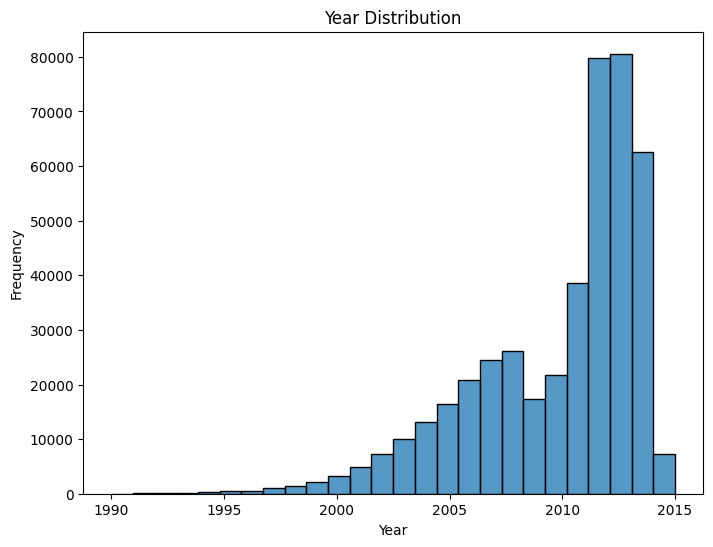

In [149]:
df_pd = df.select('year').toPandas()
plt.figure(figsize=(8, 6))
sns.histplot(data=df_pd, x='year', bins=26)
plt.title('Year Distribution')
plt.xlabel('Year')
plt.ylabel('Frequency')

plt.show()

In [141]:
df_2 = df.withColumn('saledate_clean', regexp_replace(col('saledate'), ' GMT.*', ''))

In [142]:
# Convert the cleaned date string to a timestamp and then to a date
df_2 = df_2.withColumn('saledate_clean', from_unixtime(unix_timestamp(col('saledate_clean'), 'EEE MMM dd yyyy HH:mm:ss')))

# Calculate vehicle_age
df_2 = df_2.withColumn('vehicle_age', year(col('saledate_clean')) - col('year'))

In [138]:
df_2.select('year', 'saledate_clean').where(col('year') > year(col('saledate_clean'))).count()

148

In [143]:
# Set the legacy time parser policy on the existing Spark session
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [146]:
df = df_2.filter(col('year') <= year(col('saledate_clean')))

In [147]:
df.select(['year', year(col('saledate_clean')), 'vehicle_age']).sort('year').show()

+----+--------------------+-----------+
|year|year(saledate_clean)|vehicle_age|
+----+--------------------+-----------+
|1990|                2015|         25|
|1990|                2014|         24|
|1990|                2014|         24|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2014|         24|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
+----+--------------------+-----------+
only showing top 20 rows



In [150]:
df.groupBy('year').agg(avg('vehicle_age').alias('avg_vehicle_age')).sort('year').show()

+----+------------------+
|year|   avg_vehicle_age|
+----+------------------+
|1990|              24.9|
|1991|23.869565217391305|
|1992|22.816091954022987|
|1993|21.904347826086955|
|1994|20.894941634241246|
|1995| 19.87272727272727|
|1996| 18.88867924528302|
|1997|17.890382626680456|
|1998|  16.9108049311095|
|1999|15.901287553648068|
|2000|14.906472592133788|
|2001|13.908813972380178|
|2002|12.900750853242322|
|2003| 11.90941883767535|
|2004|10.907218862435888|
|2005| 9.910054512416718|
|2006| 8.907602170676656|
|2007| 7.909709212348294|
|2008| 6.912421907937603|
|2009| 5.907116451016636|
+----+------------------+
only showing top 20 rows



## Correlation Matrix

In [225]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- trim: string (nullable = true)
 |-- body: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- vin: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- color: string (nullable = true)
 |-- interior: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- mmr: integer (nullable = true)
 |-- sellingprice: integer (nullable = true)
 |-- saledate: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- saledate_clean: string (nullable = true)
 |-- vehicle_age: integer (nullable = true)



In [44]:
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml import Pipeline

In [161]:
indexers_cor = [StringIndexer(inputCol=col, outputCol=col+'_idx').fit(df) for col in ["make", "model", "transmission", "color", "body_type"]]
pipeline = Pipeline(stages=indexers_cor)
cor_df = pipeline.fit(df).transform(df)
cor_df.show()

+----+-------------+---------------+---------------+---------+------------+-----------------+-----+---------+--------+--------+--------+--------------------+-----+------------+--------------------+---------+-------------------+-----------+--------+---------+----------------+---------+-------------+
|year|         make|          model|           trim|     body|transmission|              vin|state|condition|odometer|   color|interior|              seller|  mmr|sellingprice|            saledate|body_type|     saledate_clean|vehicle_age|make_idx|model_idx|transmission_idx|color_idx|body_type_idx|
+----+-------------+---------------+---------------+---------+------------+-----------------+-----+---------+--------+--------+--------+--------------------+-----+------------+--------------------+---------+-------------------+-----------+--------+---------+----------------+---------+-------------+
|2013|    chevrolet|          cruze|            1LT|    sedan|   automatic|1g1pc5sb9d7167061|   va| 

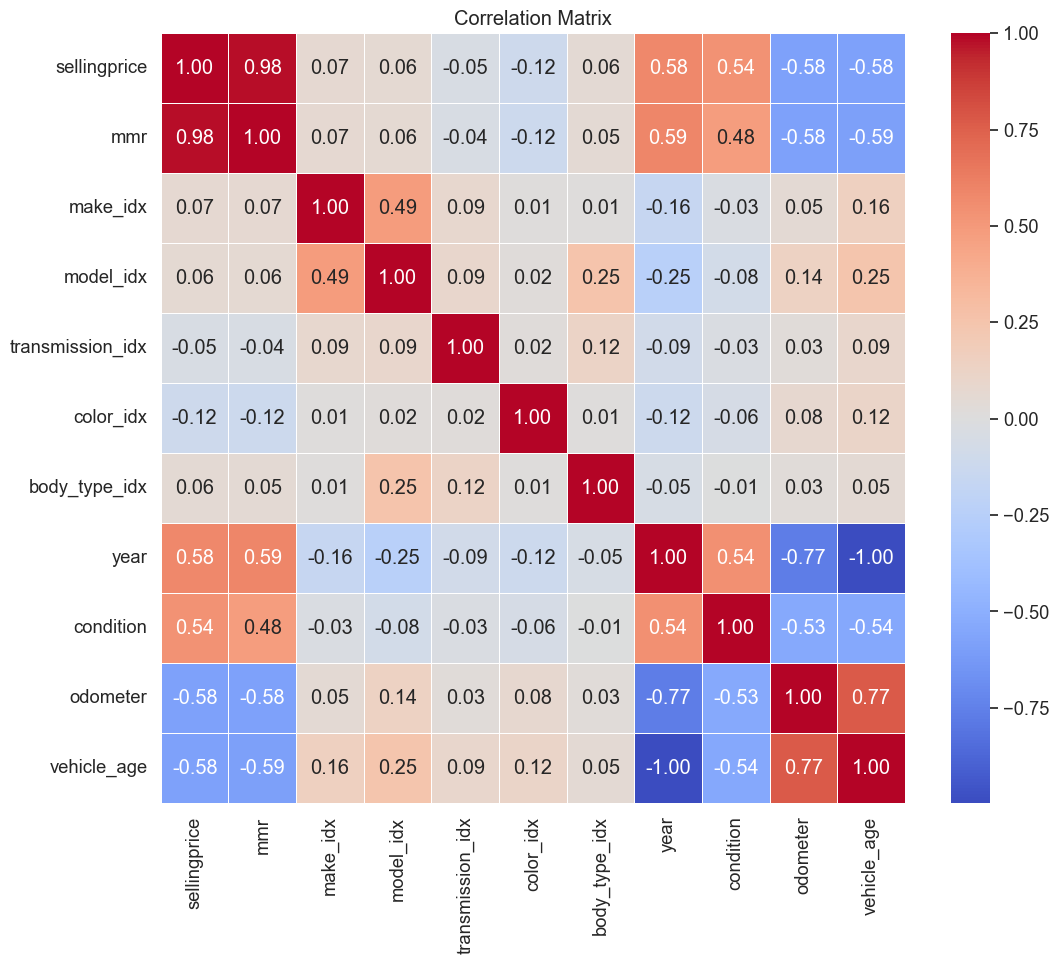

In [173]:
# Select relevant columns for correlation analysis
cols = [ "sellingprice", "mmr", "make_idx", "model_idx", "transmission_idx", "color_idx", "body_type_idx", "year", "condition", "odometer", "vehicle_age"]

# Generate the correlation matrix
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.2)
corr_matrix = cor_df.select(cols).toPandas().corr()
heatmap = sns.heatmap(data=corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

## Model-Making

In [243]:
# Feature Selection
features_df = df.select(["make", "model", "year", "body_type", "transmission", "condition", "odometer", "color", "interior", "sellingprice","mmr"])
features_df.show()

+----------+----------------+----+---------+------------+---------+--------+------+--------+-----+
|      make|           model|year|body_type|transmission|condition|odometer| color|interior|  mmr|
+----------+----------------+----+---------+------------+---------+--------+------+--------+-----+
|      ford|          fusion|2012|    sedan|   automatic|      3.1|   86927|   red|   black| 8150|
|    toyota|          sienna|2014|  minivan|   automatic|      4.4|   24913|  gray|    gray|21300|
| chevrolet|             hhr|2008|    wagon|   automatic|      4.2|   66269|  gold|   black| 5800|
|     honda|           civic|2012|    sedan|   automatic|      3.4|   35852|  blue|    gray|11050|
|      ford|          fiesta|2011|    sedan|   automatic|      4.7|   52164|silver|   black| 7300|
|    subaru|         outback|2006|    wagon|   automatic|      3.7|   31414| black|   black| 9575|
|    nissan|           rogue|2012|      suv|   automatic|      4.1|   61656|  gray|   black|12350|
|    nissa

In [227]:
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml import Pipeline

In [244]:
indexers = [StringIndexer(inputCol=col, outputCol=col+'_idx').fit(features_df) for col in ["make", "body_type", "model"]]
pipeline = Pipeline(stages=indexers)
features_df = pipeline.fit(features_df).transform(features_df)
features_df.show()
#, "transmission", "color"

+----------+----------------+----+---------+------------+---------+--------+------+--------+-----+--------+-------------+
|      make|           model|year|body_type|transmission|condition|odometer| color|interior|  mmr|make_idx|body_type_idx|
+----------+----------------+----+---------+------------+---------+--------+------+--------+-----+--------+-------------+
|      ford|          fusion|2012|    sedan|   automatic|      3.1|   86927|   red|   black| 8150|     0.0|          0.0|
|    toyota|          sienna|2014|  minivan|   automatic|      4.4|   24913|  gray|    gray|21300|     3.0|          4.0|
| chevrolet|             hhr|2008|    wagon|   automatic|      4.2|   66269|  gold|   black| 5800|     1.0|          6.0|
|     honda|           civic|2012|    sedan|   automatic|      3.4|   35852|  blue|    gray|11050|     5.0|          0.0|
|      ford|          fiesta|2011|    sedan|   automatic|      4.7|   52164|silver|   black| 7300|     0.0|          0.0|
|    subaru|         out

In [245]:
assembler = VectorAssembler(
    inputCols=["make_idx", "body_type_idx", "year", "condition", "model_idx"],
    outputCol="features"
)
features_df = assembler.transform(features_df)
features_df.show(truncate=False)
#"sellingprice_idx", "transmission_idx", "color_idx"

+----------+----------------+----+---------+------------+---------+--------+------+--------+-----+--------+-------------+---------------------+
|make      |model           |year|body_type|transmission|condition|odometer|color |interior|mmr  |make_idx|body_type_idx|features             |
+----------+----------------+----+---------+------------+---------+--------+------+--------+-----+--------+-------------+---------------------+
|ford      |fusion          |2012|sedan    |automatic   |3.1      |86927   |red   |black   |8150 |0.0     |0.0          |[0.0,0.0,2012.0,3.1] |
|toyota    |sienna          |2014|minivan  |automatic   |4.4      |24913   |gray  |gray    |21300|3.0     |4.0          |[3.0,4.0,2014.0,4.4] |
|chevrolet |hhr             |2008|wagon    |automatic   |4.2      |66269   |gold  |black   |5800 |1.0     |6.0          |[1.0,6.0,2008.0,4.2] |
|honda     |civic           |2012|sedan    |automatic   |3.4      |35852   |blue  |gray    |11050|5.0     |0.0          |[5.0,0.0,2012.0

In [246]:
features_vector_df = features_df.select(['features','mmr'])
features_vector_df = features_vector_df.withColumn('mmr', features_vector_df['mmr'].cast(IntegerType()))
features_vector_df.show(truncate=False)

+---------------------+-----+
|features             |mmr  |
+---------------------+-----+
|[7.0,7.0,2012.0,4.2] |24200|
|[5.0,1.0,2011.0,3.5] |20300|
|[1.0,1.0,2008.0,2.8] |4275 |
|[19.0,1.0,2012.0,3.8]|25700|
|[1.0,0.0,2009.0,4.3] |6625 |
|[10.0,0.0,2012.0,4.7]|21000|
|[13.0,0.0,2008.0,3.4]|22400|
|[3.0,0.0,2013.0,4.4] |11350|
|[3.0,0.0,2010.0,2.1] |7150 |
|[14.0,0.0,2006.0,2.8]|3800 |
|[4.0,4.0,2014.0,3.0] |17250|
|[4.0,1.0,2005.0,3.0] |4075 |
|[5.0,4.0,2005.0,2.8] |4975 |
|[2.0,0.0,2011.0,2.0] |9525 |
|[2.0,0.0,2009.0,3.1] |4800 |
|[15.0,1.0,2008.0,2.9]|14050|
|[4.0,1.0,2004.0,1.9] |2125 |
|[0.0,1.0,2013.0,4.8] |19500|
|[10.0,0.0,2012.0,4.1]|28200|
|[0.0,0.0,2007.0,2.4] |3625 |
+---------------------+-----+
only showing top 20 rows



In [247]:
(trainData, testData) = features_vector_df.randomSplit([0.83, 0.17], seed=42)

In [248]:
trainData.show()

+--------------------+---+
|            features|mmr|
+--------------------+---+
|[0.0,0.0,1996.0,1.0]|500|
|[0.0,0.0,1996.0,1.0]|650|
|[0.0,0.0,1996.0,2.0]|575|
|[0.0,0.0,1996.0,2.0]|600|
|[0.0,0.0,1997.0,1.0]|350|
|[0.0,0.0,1997.0,1.9]|850|
|[0.0,0.0,1997.0,2.0]|675|
|[0.0,0.0,1997.0,2.4]|800|
|[0.0,0.0,1997.0,2.6]|650|
|[0.0,0.0,1997.0,2.7]|400|
|[0.0,0.0,1998.0,1.9]|375|
|[0.0,0.0,1998.0,1.9]|400|
|[0.0,0.0,1998.0,1.9]|400|
|[0.0,0.0,1998.0,2.0]|775|
|[0.0,0.0,1998.0,2.7]|850|
|[0.0,0.0,1999.0,1.0]|700|
|[0.0,0.0,1999.0,1.0]|700|
|[0.0,0.0,1999.0,1.0]|750|
|[0.0,0.0,1999.0,1.9]|575|
|[0.0,0.0,1999.0,1.9]|600|
+--------------------+---+
only showing top 20 rows



In [182]:
# Import classification models

from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, LinearRegression

### Random Forest

In [254]:
rf = RandomForestRegressor(labelCol="mmr", featuresCol="features", maxBins=761).fit(trainData)

In [255]:
predictedDataRF = rf.transform(testData)
predictedDataRF.show()

+--------------------+----+------------------+
|            features| mmr|        prediction|
+--------------------+----+------------------+
|[0.0,0.0,1996.0,2.0]| 475|2452.7270896570267|
|[0.0,0.0,1997.0,1.7]| 575|2452.7270896570267|
|[0.0,0.0,1997.0,2.0]| 600|2452.7270896570267|
|[0.0,0.0,1997.0,2.8]| 375| 2956.218436159469|
|[0.0,0.0,1998.0,2.8]| 650| 2956.218436159469|
|[0.0,0.0,1999.0,1.9]| 450|2452.7270896570267|
|[0.0,0.0,1999.0,3.1]| 775|3401.1134240433844|
|[0.0,0.0,2000.0,1.9]|1050|2452.7270896570267|
|[0.0,0.0,2000.0,2.0]| 650|2452.7270896570267|
|[0.0,0.0,2000.0,2.0]|1100|2452.7270896570267|
|[0.0,0.0,2000.0,2.0]|1500|2452.7270896570267|
|[0.0,0.0,2000.0,2.5]| 375|2452.7270896570267|
|[0.0,0.0,2000.0,3.8]|1175| 4253.009498145293|
|[0.0,0.0,2001.0,1.9]| 800|2452.7270896570267|
|[0.0,0.0,2001.0,2.0]| 800|2452.7270896570267|
|[0.0,0.0,2002.0,1.0]| 725|2585.5071572717084|
|[0.0,0.0,2002.0,1.9]|6275|2585.5071572717084|
|[0.0,0.0,2002.0,2.1]| 725|2585.5071572717084|
|[0.0,0.0,200

### Linear Regression

In [238]:
lr = LinearRegression(labelCol="mmr", featuresCol="features")

In [239]:
# Fit the LinearRegression model to the training data
lrModel = lr.fit(trainData)

# Use the trained model to make predictions on the test data
predictedDataLR = lrModel.transform(testData)

# Show the predicted data
predictedDataLR.show()

24/05/23 23:35:47 WARN Instrumentation: [f4161af3] regParam is zero, which might cause numerical instability and overfitting.


+--------------------+----+-------------------+
|            features| mmr|         prediction|
+--------------------+----+-------------------+
|[0.0,1.0,2.0,1997...|1050|  -8388.49006060278|
|[0.0,1.0,2.0,1997...|2400|  -8388.49006060278|
|[0.0,1.0,2.0,1997...|1475| -8181.722684533335|
|[0.0,1.0,2.0,1998...|1150| -8939.722815691493|
|[0.0,1.0,2.0,1998...|1875| -7078.816431066487|
|[0.0,1.0,2.0,1999...|2075| -5769.142801529728|
|[0.0,1.0,2.0,2000...|1850| -2598.562787368428|
|[0.0,1.0,2.0,2001...|4000|-3149.7955424566753|
|[0.0,1.0,2.0,2001...|4100|-3149.7955424566753|
|[0.0,1.0,2.0,2001...|2875|  -2943.02816638723|
|[0.0,1.0,2.0,2001...|4275|  -2943.02816638723|
|[0.0,1.0,2.0,2001...|3475|-1702.4239099705592|
|[0.0,1.0,2.0,2002...|2300|-3701.0282975453883|
|[0.0,1.0,2.0,2002...|2525|-1840.1219129203819|
|[0.0,1.0,2.0,2002...|2650|-1633.3545368509367|
|[0.0,1.0,2.0,2003...|3450| -530.4482833836228|
|[0.0,1.0,2.0,2003...|4200|  89.85384482471272|
|[0.0,1.0,2.0,2003...|7775|  296.6212208

### Gradient Boosted

In [256]:
gbt = GBTRegressor(labelCol="mmr", featuresCol="features", maxBins = 60)

In [257]:
# Fit the LinearRegression model to the training data
gbtModel = gbt.fit(trainData)

# Use the trained model to make predictions on the test data
predictedDataGBT = gbtModel.transform(testData)

# Show the predicted data
predictedDataGBT.show()

+--------------------+----+------------------+
|            features| mmr|        prediction|
+--------------------+----+------------------+
|[0.0,0.0,1996.0,2.0]| 475|  732.991696439143|
|[0.0,0.0,1997.0,1.7]| 575|  732.991696439143|
|[0.0,0.0,1997.0,2.0]| 600|  732.991696439143|
|[0.0,0.0,1997.0,2.8]| 375| 1067.655733620657|
|[0.0,0.0,1998.0,2.8]| 650| 1067.655733620657|
|[0.0,0.0,1999.0,1.9]| 450| 956.5840226142152|
|[0.0,0.0,1999.0,3.1]| 775|1470.4757644780334|
|[0.0,0.0,2000.0,1.9]|1050|1078.7264770768213|
|[0.0,0.0,2000.0,2.0]| 650|1078.7264770768213|
|[0.0,0.0,2000.0,2.0]|1100|1078.7264770768213|
|[0.0,0.0,2000.0,2.0]|1500|1078.7264770768213|
|[0.0,0.0,2000.0,2.5]| 375|1126.3941036340664|
|[0.0,0.0,2000.0,3.8]|1175|1899.0523753395898|
|[0.0,0.0,2001.0,1.9]| 800| 1252.107958904391|
|[0.0,0.0,2001.0,2.0]| 800| 1252.107958904391|
|[0.0,0.0,2002.0,1.0]| 725|1559.4482241833864|
|[0.0,0.0,2002.0,1.9]|6275|1559.4482241833864|
|[0.0,0.0,2002.0,2.1]| 725|1607.1158507406312|
|[0.0,0.0,200

## Model Evaluation

In [198]:
# Import evaluation models

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics


### Random Forest

In [258]:
evaluator1 = RegressionEvaluator(
    labelCol="mmr", predictionCol="prediction", metricName="rmse")
evaluator2 = RegressionEvaluator(
    labelCol="mmr", predictionCol="prediction", metricName="mse")
evaluator3 = RegressionEvaluator(
    labelCol="mmr", predictionCol="prediction", metricName="r2")
rmse = evaluator1.evaluate(predictedDataRF)
mse = evaluator2.evaluate(predictedDataRF)
r2 = evaluator3.evaluate(predictedDataRF)
print("Root Mean Squared Error (RMSE)", rmse)
print("Mean Squared Error (MSE)", mse)
print("R-squared (R²)", r2)

Root Mean Squared Error (RMSE) 5058.197210360737
Mean Squared Error (MSE) 25585359.01890114
R-squared (R²) 0.711080482132586


In [259]:
predictions = predictedDataRF.withColumn("ape", abs((col("mmr") - col("prediction")) / col("mmr")))
mape = predictions.select(mean(col("ape"))).collect()[0][0] * 100

print(f"Mean Absolute Percentage Error (MAPE) on test data = {mape}%")

Mean Absolute Percentage Error (MAPE) on test data = 38.90868814537291%


### Linear Regression

In [240]:
evaluator1 = RegressionEvaluator(
    labelCol="mmr", predictionCol="prediction", metricName="rmse")
evaluator2 = RegressionEvaluator(
    labelCol="mmr", predictionCol="prediction", metricName="mse")
evaluator3 = RegressionEvaluator(
    labelCol="mmr", predictionCol="prediction", metricName="r2")
rmse = evaluator1.evaluate(predictedDataLR)
mse = evaluator2.evaluate(predictedDataLR)
r2 = evaluator3.evaluate(predictedDataLR)
print("Root Mean Squared Error (RMSE)", rmse)
print("Mean Squared Error (MSE)", mse)
print("R-squared (R²)", r2)

Root Mean Squared Error (RMSE) 7032.623407311401
Mean Squared Error (MSE) 49457791.98906422
R-squared (R²) 0.4353174422038686


In [241]:
predictions = predictedDataLR.withColumn("ape", abs((col("mmr") - col("prediction")) / col("mmr")))
mape = predictions.select(mean(col("ape"))).collect()[0][0] * 100

print(f"Mean Absolute Percentage Error (MAPE) on test data = {mape}%")

Mean Absolute Percentage Error (MAPE) on test data = 66.41334733512191%


### Gradient Boosted

In [260]:
evaluator1 = RegressionEvaluator(
    labelCol="mmr", predictionCol="prediction", metricName="rmse")
evaluator2 = RegressionEvaluator(
    labelCol="mmr", predictionCol="prediction", metricName="mse")
evaluator3 = RegressionEvaluator(
    labelCol="mmr", predictionCol="prediction", metricName="r2")
rmse = evaluator1.evaluate(predictedDataGBT)
mse = evaluator2.evaluate(predictedDataGBT)
r2 = evaluator3.evaluate(predictedDataGBT)
print("Root Mean Squared Error (RMSE)", rmse)
print("Mean Squared Error (MSE)", mse)
print("R-squared (R²)", r2)

Root Mean Squared Error (RMSE) 4487.275016381302
Mean Squared Error (MSE) 20135637.07263981
R-squared (R²) 0.7726207964999593


In [261]:
predictions = predictedDataGBT.withColumn("ape", abs((col("mmr") - col("prediction")) / col("mmr")))
mape = predictions.select(mean(col("ape"))).collect()[0][0] * 100

print(f"Mean Absolute Percentage Error (MAPE) on test data = {mape}%")

Mean Absolute Percentage Error (MAPE) on test data = 28.664560693914527%
